80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Iteration 0: Loss 555694848.0000
Iteration 100: Loss 7565019.0000
Iteration 200: Loss 5250910.0000
Iteration 300: Loss 4464479.0000
Iteration 400: Loss 3917894.5000


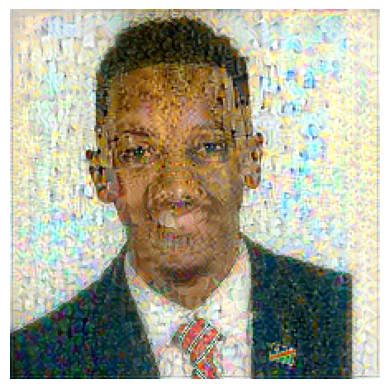

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image as kp_image

# Load and preprocess image
def load_and_process_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg19.preprocess_input(tf.expand_dims(img, axis=0))
    return img

def deprocess_image(processed_img):
    x = processed_img.copy()
    x = x.reshape((224, 224, 3))
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load images
content_path = '/content/sample_data/123.jpg'
style_path = '/content/sample_data/klimt.jpg'
content_image = load_and_process_image(content_path)
style_image = load_and_process_image(style_path)

# Define content and style layers
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
num_content = len(content_layers)
num_style = len(style_layers)

# Load VGG19 model
def get_model():
    vgg = vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in style_layers + content_layers]
    model = Model([vgg.input], outputs)
    return model

# Gram matrix
def gram_matrix(tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', tensor, tensor)
    input_shape = tf.shape(tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# Extract features
def get_feature_representations(model, content_img, style_img):
    style_outputs = model(style_img)
    content_outputs = model(content_img)
    style_features = [gram_matrix(output) for output in style_outputs[:num_style]]
    content_features = [output for output in content_outputs[num_style:]]
    return style_features, content_features

# Compute loss
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)
    style_output_features = model_outputs[:num_style]
    content_output_features = model_outputs[num_style:]

    style_score = tf.add_n([tf.reduce_mean((gram_matrix(style_output) - gram_target)**2)
                            for style_output, gram_target in zip(style_output_features, gram_style_features)])
    style_score *= style_weight / num_style

    content_score = tf.add_n([tf.reduce_mean((content_output - content_target)**2)
                              for content_output, content_target in zip(content_output_features, content_features)])
    content_score *= content_weight / num_content

    total_loss = style_score + content_score
    return total_loss

# Optimization
@tf.function()
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    total_loss = all_loss
    return tape.gradient(total_loss, cfg['init_image']), total_loss

# Run style transfer
def run_style_transfer(content_img, style_img, iterations=1000, content_weight=1e3, style_weight=1e-2):
    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(model, content_img, style_img)
    init_image = tf.Variable(content_img, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5.0)
    best_loss = float('inf')
    best_img = None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': style_features,
        'content_features': content_features
    }

    for i in range(iterations):
        grads, loss = compute_grads(cfg)
        opt.apply_gradients([(grads, init_image)])
        if loss < best_loss:
            best_loss = loss
            best_img = init_image.numpy()
        if i % 100 == 0:
            print(f"Iteration {i}: Loss {loss:.4f}")

    return best_img

# Run transfer and display
stylized_img = run_style_transfer(content_image, style_image, iterations=500)
final_img = deprocess_image(stylized_img)
plt.imshow(final_img)
plt.axis('off')
plt.show()
